#                                        Efrem Ghebreab 
# Feature importance and selection

In [216]:
%run featimp

In Machine learning, features contain information about target variables and the prediction power of the algorithms is defined in terms of the features it contains. More features means more or better information and more classification or predictive modeling power. But in reality this is not always the case, often in high dimensional datasets, we can have irrelevant, redundant and less significant features. These types of features contribute less to the predictive modeling compared to the important features or they may have no contribution at all. Instead they create problems which are not efficient for machine learning algorithms. For example irrelevant features can cause very low accuracy in K-NN algorithms because of the noises created when we try to find which instances are close together. Redundant features which don't contribute to additional information may lead to degradation in performance of  learning algorithms. These features can cause unnecessary allocation of computational resources,  overfitting especially when we have less training examples and increases algorithm complexity. The solution for these problems is to either select a subset of important features or to transform the dimension of features into lesser dimensional space.   



Even though there are a lot of similarities between feature selection and dimension reduction(feature extraction), they are different in the process of reducing the features of a dataset. The main difference is that feature selection must always be from a subset of the original set of features by including and excluding some attributes without modifying them. But dimensionality reduction lowers the dimensional space by creating a new combination of features(feature transformation). Some of the examples include PCA, Singular Value Decomposition etc. For example, PCA can reduce dimensionality by extracting certain features, compressing them, creating synthetic features, and can get rid of the less important ones. 



Note: Redundant features aren’t the same with irrelevant features. Redundant features can be relevant to the model in the presence of other highly correlated relevant features and the process of removing such features should be different. 



# Feature Selection 

Feature selection, an important part of any machine learning workflow, is the process of selecting the most important features from a dataset  which contributes most to our target variable. There are many good reasons to remove redundant and irrelevant features and increase the importance of the significant once. Some of them are: to improve the predictive model’s performance and avoid overfitting, provide efficient and faster independent variables and permit better understanding of the model dynamics and process that gives better interpretability of the model and Dataset. There are different methods of Feature selection like filtering methods, wrapper methods and embedded methods. 





# Spearman's rank correlation coefficient:

One of the commonly used methods for feature selection is dependency measures. One of the dependency measures used is the Correlation method, which is used to identify an association between predictor features and targets as well as predictor to predictor relationship to avoid redundancy. Spearman's correlation assesses monotonic relationships which are non linear, constantly increasing or constantly decreasing,  between two variables. Spearman's correlation goes between -1 and +1, where +1 represents a strict positive monotonic relationship, -1 a negative monotonic relationship and at 0 there is no monotonic relationship. Positive relation indicates if one variable goes up, the other also goes up while a negative relation indicates if one goes down, the other goes up. Spearman's correlation coefficient is a computation of Pearson's correlation of ranks of the two variables. 


##### It has the following steps of computation on variables X and y:
1. Sort the data of X and create another column with rank of X 1,2,3...n
2. Sort the data of y and create another column with rank of y 1,2,3,
3. compute the difference between ranks of x and y
4. square the difference and compute the formula 



##### The algorithm of selecting best features using Spearman's correlation is as follows:
Input : S(F1, F2, ……., Fk, Fc ) --->  a features and target variable in training data set

Output : best features 

iterate through the features: for i = 1 to k 

compute Spearman's correlation rho = calculate correcoeff(Fi , Ftarget )

add the column names and the correlation coefficients in order by ignoring the signs. 


We also need our algorithm to consider the highly correlated features at a certain  threshold. In the breast cancer dataset we are taking a threshold of 0.8 and all of the features with a correlation above 0.8 are considered highly correlated and dependent on each other. 

# Visualize Spearman's rank correlation

In [459]:
best, corr_features = correlation(breast_dataset, 0.8)
dict_1=dict()
for feat,score in best:
    dict_1.setdefault(feat, []).append(score)

In [467]:
df = pd.DataFrame.from_dict(dict_1).melt().groupby(['variable']).mean().sort_values(['value'], ascending=False)[1:]

In [202]:
px.bar(df[:20], x='variable', y='value', title = 'Best features from Spearmans rank correlation')

## Breast Cancer Dataset 

To compare all the algrithms we use Breast cancer dataset and we will perform random foreset classifer as a baseline model before we compute the Feature importance and we will also recompute after implementing the algorithms. 

In [468]:
X = breast_dataset.loc[:, features]
y = breast_dataset['label']

In [469]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
pred = (clf.predict(X_test))
baseline_acu = accuracy_score(y_test, pred)
print(f"accuracy: {baseline_acu:,.4f}")

accuracy: 0.9468


### Remove Highly Correlated features and Run RF Model 

In [265]:
# Drop the highly correlated features from the data set 
less_imp = breast_dataset.drop(['worst concave points', 'worst texture', 'worst fractal dimension',
       'symmetry error', 'smoothness error', 'compactness error',
       'mean texture', 'mean smoothness', 'mean radius', 'mean perimeter'], axis=1) 


In [268]:
X_corr = less_imp
y_corr = less_imp['label']
X_train, X_test, y_train, y_test = train_test_split(X_corr, y_corr, test_size=0.33, random_state=42)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
pred = (clf.predict(X_test))
spearmans_acc = accuracy_score(y_test, pred)
print(f"accuracy: {spearmans_acc:,.4f}")

accuracy: 0.9840


The accuracy after removing the redundant features has improved from 95.2% to 98.4%, so our algorithm efficiently working. 

# Maximum Relevance - Minimum Redundancy:

In Spearman's Correlation for feature selection we can get the most important features which have high correlation with the target variable for optimal model prediction. We have also seen how to get the highly correlated features to be removed from the dataset to avoid redundancy. But this approach doesn't work well on codependent features and to deal with co-dependencies other techniques will be needed to rank features not just by relevance but also by low redundancy. This is where the Maximum Relevance - Minimum Redundancy comes in handy. mRMR is an iterative algorithm that helps us select features that have maximum relevance with response variables and minimum redundancy with other features that have been selected previously.


## mRMR Algorithm:

Computing the mRMR algorithms starts with selecting the number of features we want to have. Up on iteration it selects the best relevant feature and adds it to a list. The feature is selected based upon a  score computed by dividing the relevance of a feature with a target as F-statistic and redundancy is calculated as the average of correlation between the selected features and the feature. The feature with the highest score means it is highly relevant predictor and it has lower redundancy with any of the selected features, so it will be a candidate to be selected. 

###### Score(f) = relevance(f/target)/redundacny(f/features selected) 

1. Compute F statistic of every feature with respect the target variable 
2. Compute Correlation of every feature with respect to other features(feature to feature)
3. Initialize buckets to collect the selected features and the excluded features
4. Iterate in range of the numbers of features we want to have. 
5. Compute the scores for the currently not selected features 
6. Select a feature that has the highest score and add it to the selected list while removing from the non selected ones. 
7. Repeat the process  (K-1) times to select K features 


In [470]:
best = mRMR(X, y, 15)

In [252]:
df_mRMR = pd.DataFrame.from_dict(best).melt().groupby(['variable']).mean().reset_index().sort_values(['value'], ascending=False)[1:]


In [255]:
px.bar(df_mRMR, y='variable', x='value', title = 'Best features from mRMR')

In [270]:
most_imp = breast_dataset[['worst perimeter','mean concave points','worst radius','mean perimeter','worst area',
 'mean radius','mean concavity','worst concavity','mean area','worst compactness','mean compactness','worst texture',
 'radius error','perimeter error', 'label']]


In [272]:
X = most_imp.drop('label', axis=1)
y = most_imp['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
pred = (clf.predict(X_test))
acu_mRMR = accuracy_score(y_test, pred)
print(f"accuracy: {acu_mRMR:,.4f}")

accuracy: 0.9574


# Principal Component Analysis (PCA):

Dimensionality reduction methods aim to overcome an important obstacle to understanding the underlying structure of data. Dimensions are features or attributes that contain information to represent the data and Dimensionality is the number of the features described in a dataset. High dimensionality may introduce sparseness in the feature space of the training data that could require unnecessary computational resources. Additionally, the performance  of the predictive model could degrade and can get much more difficult to interpret the data and know the patterns. This phenomenon is called the curse of dimensionality. To overcome this problem we can use dimensionality reduction techniques like PCA. 


Principal Component Analysis (PCA) is a dimensionality reduction technique that  transforms features from a high-dimensional space into uncorrelated series of lower dimensional components. After projection of the high dimensional space to lower one we expect the features to be uncorrelated and not redundant. This is because the correlated features from the original features contribute to the formation of the same component, thereby reducing the original data features into uncorrelated principal components. Additionally, the newly created features should contain high variance with the first component having the most variance in the data and each subsequent component having lesser. This is because if the feature takes similar value for all the instances that feature cannot be used as a discriminator, so since we want the features to be able to distinguish between targets larger variation or larger variance between the features is encouraged. 

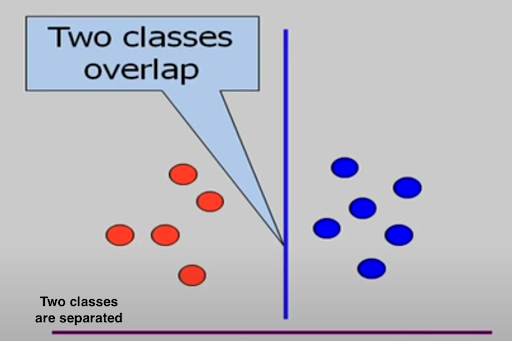

The principal components are simply the reduced dimensions and are straight lines as we can see in the picture above. When we project orange points and blue points on the blue axis they will overlap each other, so this is not a very good axis to separate the points. But if we choose the pink axis and project the points on this axis the orange and blue points are separated. This means that the pink line is the best axis to transform these features into a new dimension. 



### Plot of Iris Data set before Dimension reduction in PCA 

In [146]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

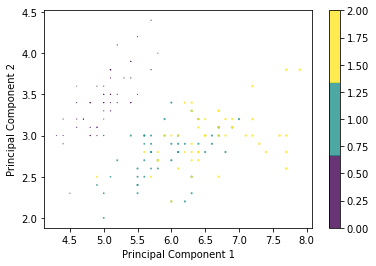

In [147]:
plt.scatter(X[:,0], X[:,1],X[:,2],
        c=y, edgecolor='none', alpha=0.8,
        cmap=plt.cm.get_cmap('viridis', 3))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

#### Fit the model and transform the Data 

In [149]:
pca = PCA(2)
vecs, eigen_values = pca.fit(X)

X_transformed = pca.transform(X)

c1 = X_transformed[:,0]
c2 = X_transformed[:,1]

### Plot of Iris Data set before Dimension reduction in PCA

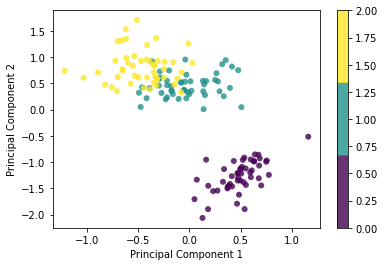

In [152]:
plt.scatter(c1, c2,
        c=y, edgecolor='none', alpha=0.8,
        cmap=plt.cm.get_cmap('viridis', 3))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

As we can see in the plots above on the iris data set, we can clearly see the difference in the distribution of the points before PCA transformation in the first plot and after transformation in the second plot.
In the first plot it is hard to classify the points in to their respective features and also hard to visualize the plot. But in the second scatter plot the features are clearly separated from one another and there is clear classification among them.   

### The PCA algrothm and Processes 

The first step in the process of dimension reduction with PCA is to centre the data by subtracting the mean and standardizing the data since the output is influenced based on the scale of the features. This will move the data to a different position within the same coordinate system. Then we calculate the covariance matrix of the centred and scaled data and this will tell us how two variables differ from each other. Next we compute the eigendecomposition of the covariance matrix into respective eigenvectors and eigenvalues. Principal components have both magnitude and direction where direction represents principal axes the data is mostly spread out and the magnitude signifies the amount of spread. Eigen vectors represent the directions while Eigen values represent the amount of spread. Finally, we reorder the rearrangement of the Eigenvalues to ensure the principal component with the highest amount of spread or variance to be the first one. 


In [153]:
print('Shape of X before PCA:', X.shape)
print('Shape of transformed X:', X_transformed.shape)

Shape of X before PCA: (150, 4)
Shape of transformed X: (150, 2)


### Variance of the Compenents 

[0.92461872 0.05306648 0.01710261 0.00521218]


<BarContainer object of 4 artists>

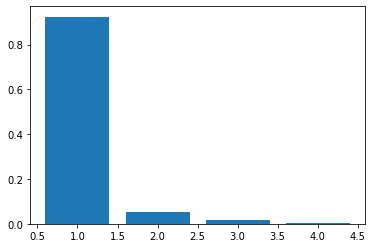

In [11]:
variance =eigen_values/sum(eigen_values)
print(variance)
plt.bar(range(1,5),variance)

As we can see on the plot the first principal Component has around 92% of the total vairance and the variance is lowering in the next components. 

In [352]:
pca = PCA(20)
pca.fit(X_train)

# X_transformed = pca.transform(X)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [354]:
clf = RandomForestClassifier()
clf.fit(X_train_pca, y_train)
pred = (clf.predict(X_test_pca))
pca_accu = accuracy_score(y_test, pred)
print(f"accuracy: {pca_accu:,.4f}")

accuracy: 0.9574


#  Permutation Importance: 

Permutation importance is a technique that is calculated to measure the increase in model prediction error or decrease in model score after the features are shuffled. This process tells us if columns are randomly shuffled which in turn breaks the relationship between the feature and the target, how that shuffling could affect the models performance. The feature will be important if shuffling drops the model's performance, meaning the feature has important information to make predictive modeling or the model is highly dependent on the feature to make prediction. On the other hand if permutation doesn’t change the error of the model or performance of the model then feature is not significant to the target. Permutation importance is usually calculated after a model has been trained and unlike drop column importance we don’t need to retrain it again during the process of shuffling. 


# Permutation Importance algorithm:


1. Initialize by Estimating the original model error which was trained on all features. 

2. Iterate through all features in the dataset then 

3. Break the relationship between the feature and target by applying permutation on the feature. 

4. Compute the evaluation metric on the permuted data 

5. Compute the difference in evaluation metric between the base line and the one measured on the permuted data. 

6. Sort the features in descending order so that the most important features will be at the top with high Error difference. 	

#### Permutation importance on Breast Cancer Dataset

In [472]:
baseline, scores=permutation_importances(X_test, y_test, clf, accuracy_score, num_iter=10)

In [473]:
percent_changes = changes(X, scores,baseline)

In [480]:
df = pd.DataFrame.from_dict(percent_changes).melt().groupby(['variable']).mean().reset_index().sort_values(['value'], ascending=False)[:10]

In [484]:
px.bar(df, x='variable', y='value')

As we can see on the plot above the most important features are  worst perimeter, worst concave points, worst area,worst radius, area error, worst texture, mean perimeter and sop on. 

### Random Forest on selected features 

In [482]:
features = df.variable[:10].values

In [364]:
selected = breast_dataset[['worst perimeter', 'worst concave points', 'worst area',
       'worst radius', 'area error', 'worst texture', 'mean perimeter',
       'mean texture', 'mean radius', 'mean area', 'label']]

In [367]:
X = selected.drop('label', axis=1)
y = selected['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
pred = (clf.predict(X_test))
perm_acu = accuracy_score(y_test, pred)
print(f"accuracy: {perm_acu:,.4f}")

accuracy: 0.9787


The accuracy score, after some of the less significant features are droped, becomes 97.9% which is higher than the accuracy with out applying permutation importance 95.2%. So our permutation importance function is performing well on identifying the most important features for the machine learning algorithm.    

# Drop-Column Importance: 

Drop-Column Importance as its name implies, is a technique computed to measure model performance by investigating the importance of a feature while a model is being trained in the presence of all features and when a feature is dropped. It is an iterative and brute force mechanism where the model is retrained after each dropped column. Generally it is more accurate feature importance but computationally expensive as we retrain the model  after dropping a single feature from the data set.

# Drop-Column Importance Algorithm:


The algorithm is pretty similar to that of Permutation Importance except we have to retrain the model and also we have to drop features instead of shuffling them. 

1. Initialize by Estimating the baseline model error which was trained on all features
2. Iterate through all features in the dataset then 
3. Drop one column and retrian the model 
4. Compute the evaluation metric on the retrained model 
5. Compute the difference in evaluation metric between the base line and the retrained model without that dropped feature. 
6. Then by sorting the features in descending order we can get the most important features ( i.e most important features will be at the top with high Error difference). 
 


In [423]:
baseline, imp=dropcol_importances(clf, X_test, y_test)

In [371]:
drops = drop_changes(X_test, imp, baseline)
df = pd.DataFrame.from_dict(drops).melt().groupby(['variable']).mean().reset_index().sort_values(['value'], ascending=False)[:25]

In [372]:
px.bar(df, x='variable', y='value')

### Random Forest on selected features

In [379]:
feat = df.variable[:14].values
most_imp = breast_dataset[['worst concave points', 'worst texture', 'worst fractal dimension',
       'symmetry error', 'smoothness error', 'compactness error',
       'mean texture', 'mean smoothness', 'mean radius', 'mean perimeter', 'label']]

In [380]:
X = most_imp.drop('label', axis=1)
y = most_imp['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
pred = (clf.predict(X_test))
drop_acu = accuracy_score(y_test, pred)
print(f"accuracy: {drop_acu:,.4f}")

accuracy: 0.9681


The accuracy score is higher than the baseline. 

# Putting all Together and Comparing Strategies  

In [417]:
accuracies = {'spearmans corr':[spearmans_acc], 'mRMR': [acu_mRMR], 'PCA': [pca_accu], 'Permu imp':[perm_acu], 
              'drop col':[drop_acu], 'baseline':[baseline_acu]
             }

In [418]:
df = pd.DataFrame.from_dict(accuracies).melt().groupby(['variable']).mean().reset_index().sort_values(['value'], ascending=False)[0:5]

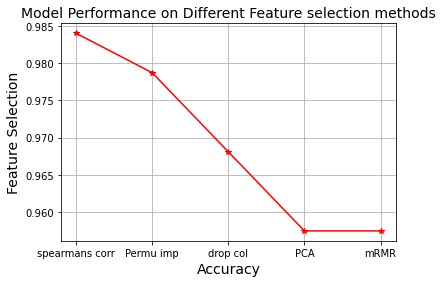

In [419]:
plt.plot(df.variable, df.value, color='red', marker='*')
plt.title('Model Performance on Different Feature selection methods', fontsize=14)
plt.xlabel('Accuracy', fontsize=14)
plt.ylabel('Feature Selection', fontsize=14)
plt.grid(True)
plt.show()

On Breast Cancer dataset the Performace of the models after feature importance was performed is plotted on the above graph. As we can see, the performance after highly redundant features removed through the spearman's correlation computation on the dataset has the highest accuracy score. The accuracy of the models after PCA and mRMR feature importance techniques were generally lower than other techniques. Overall, the models performace has increased after feature importance was applied and was greater than the baseline on all techniques.  

# Summary 

In this project we have covered one of the most important topic in machine learning which is feature importance and selection. We have explored different variety of the techniques used to select important features including spearmans correlation, mRMR, PCA, permutation importance and Drop column importances. The performance of each technique on prediction was analyzed and all of them were efficient. Feature importance is significant to train machine learning algorithm faster, reduce complexity and prevent overfitting. So it should be the first step on building machine learning models.  